# TP Final

Autor: Abraham Rodriguez 

Repositorio: https://github.com/AbeRodz/Time-series


## Proposito 

Este proyecto consiste en utilzar datos de yahoo finance para analizar y predecir el stock de AAPL.

# Importacion y utilidades

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Physical GPUs:", physical_devices)

Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def plot_prediction_dayrange(df:pd.DataFrame, predictions: np.ndarray, time_range:int):


    plt.figure(figsize=(10,6))
    plt.plot(df[-time_range:].index, df[-time_range:], label='Datos Reales')
    plt.plot(df[-time_range:].index, predicted_prices[-time_range:], label='Predicción LSTM')
    plt.legend()
    plt.title('Pronóstico de precios de cierre ajustado con LSTM')
    plt.show()


## Descargando datos

In [63]:
ticker = 'AAPL'
data = yf.download(ticker, start="2015-01-01", end="2024-09-30")

data_close = data[['Adj Close']]

[*********************100%***********************]  1 of 1 completed


In [88]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373957,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687302,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689529,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021713,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000
...,...,...,...,...,...,...
2024-09-23,227.339996,229.449997,225.809998,226.470001,226.470001,54146000
2024-09-24,228.649994,229.350006,225.729996,227.369995,227.369995,43556100
2024-09-25,224.929993,227.289993,224.020004,226.369995,226.369995,42308700


## Creacion de dataset

In [66]:
# Usar 80% de los datos para entrenamiento y 20% para prueba
train_size = int(len(data_close) * 0.8)
train_data, test_data = data_close[:train_size], data_close[train_size:]
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de prueba: {len(test_data)}")

Tamaño del conjunto de entrenamiento: 1960
Tamaño del conjunto de prueba: 491


In [67]:
time_step = 60

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Reshape input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


#  Modelo #1 (Red LSTM)

La arquitectura consiste en una red neuronal recurrente LSTM simple con las siguientes capas y sus caracterisitcas:

- Capa LSTM, gracias a la cualidad de "olvidarse de data muy lejana" son aptas para stocks ya que no existe un patron que permita predecir n dias en el futuro. Sin embargo se necesita el contexto de m dias en el pasado.

- Capa Dropout, ayuda al modelo a generalizar y reduce el overfitting apagando neuronas con una probabilidad p.
- Capa Densa Lineal, una simple proyeccion lineal.


- Optimizador Adam y funcion de perdida MSE.


In [69]:
from tensorflow.keras.optimizers import Adam
def prepare_model(learning_rate=1e-3) -> tf.keras.Model:
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=25))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
    return model


In [70]:
from tensorflow.keras.callbacks import EarlyStopping
model_lstm = prepare_model(learning_rate=1e-3)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



/Users/rodz/Documents/projects/Time-series/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
model_lstm.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0422 - mae: 0.1365 - mse: 0.0422 - val_loss: 0.0047 - val_mae: 0.0569 - val_mse: 0.0047
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0055 - mae: 0.0556 - mse: 0.0055 - val_loss: 0.0018 - val_mae: 0.0349 - val_mse: 0.0018
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0035 - mae: 0.0341 - mse: 0.0035 - val_loss: 0.0098 - val_mae: 0.0915 - val_mse: 0.0098
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0033 - mae: 0.0333 - mse: 0.0033 - val_loss: 0.0027 - val_mae: 0.0425 - val_mse: 0.0027
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0025 - mae: 0.0298 - mse: 0.0025 - val_loss: 0.0016 - val_mae: 0.0320 - val_mse: 0.0016
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0025 - mae: 0.0276 - mse: 0.0025 - val_loss: 0.0035 - val_mae: 0.0494 - val_mse: 0.0035
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0019 - mae: 0.0267 - mse: 0.0019 - val_loss:

In [73]:
lstm_predictions_test = model_lstm.predict(X_test)
lstm_predictions_test_rescaled = scaler.inverse_transform(lstm_predictions_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


In [74]:
# Evaluar el rendimiento del modelo LSTM en el conjunto de prueba
rmse_lstm_test = np.sqrt(mean_squared_error(test_data['Adj Close'][time_step:], lstm_predictions_test_rescaled))
mae_lstm_test = mean_absolute_error(test_data['Adj Close'][time_step:], lstm_predictions_test_rescaled)

print(f'LSTM RMSE (Test): {rmse_lstm_test}')
print(f'LSTM MAE (Test): {mae_lstm_test}')


LSTM RMSE (Test): 6.259664746811807
LSTM MAE (Test): 4.904408465958527


# Visualizacion de resultados LSTM

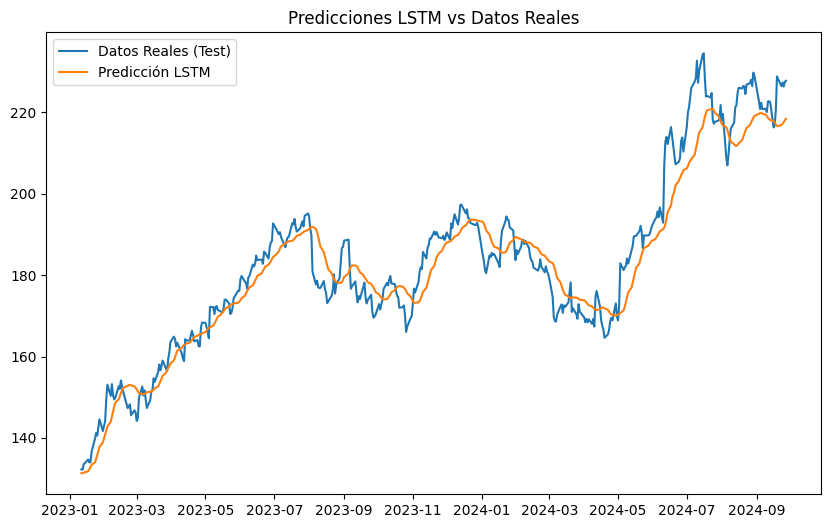

In [75]:
plt.figure(figsize=(10,6))
plt.plot(test_data.index[time_step:], test_data['Adj Close'][time_step:], label='Datos Reales (Test)')
plt.plot(test_data.index[time_step:], lstm_predictions_test_rescaled, label='Predicción LSTM')
plt.legend()
plt.title('Predicciones LSTM vs Datos Reales')
plt.show()

# Analisis y resultados

La red LSTM se comporta muy bien al predecir las tendencias a lo largo del tiempo.
El error RMSE es relativamente bajo en testeo: 7.701

# Modelo #2 (ARIMA)

In [76]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train_data, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

forecast_arima_test = model_arima_fit.forecast(steps=len(test_data))

/Users/rodz/Documents/projects/Time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rodz/Documents/projects/Time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rodz/Documents/projects/Time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rodz/Documents/projects/Time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No suppor

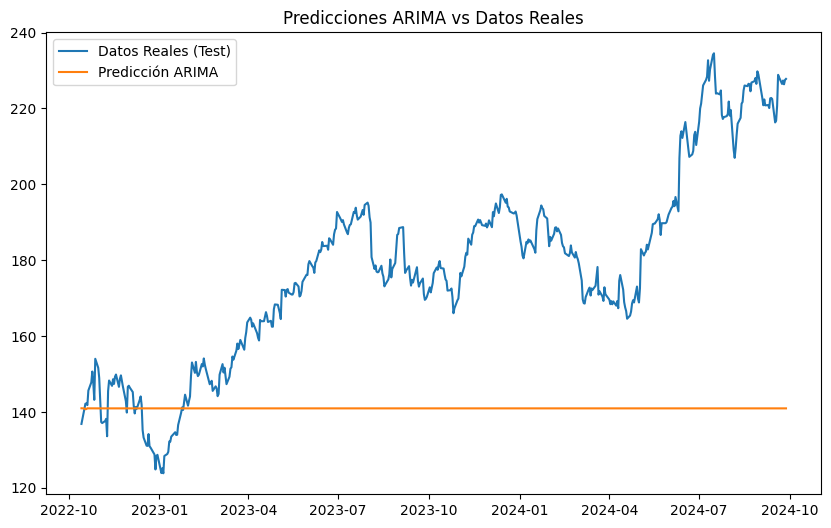

In [77]:
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data['Adj Close'], label='Datos Reales (Test)')
plt.plot(test_data.index, forecast_arima_test, label='Predicción ARIMA')
plt.legend()
plt.title('Predicciones ARIMA vs Datos Reales')
plt.show()

In [78]:
real_data = data_close["Adj Close"][-30:]

rmse_arima_test = np.sqrt(mean_squared_error(test_data, forecast_arima_test))
mae_arima_test = mean_absolute_error(test_data, forecast_arima_test)
print(f'ARIMA RMSE (Test): {rmse_arima_test}')
print(f'ARIMA MAE (Test): {mae_arima_test}')

ARIMA RMSE (Test): 44.78138474645419
ARIMA MAE (Test): 38.07789979965524


# Analisis y resultados (ARIMA)
ARIMA no se comporta nada bien, no logra interpretar las tendencias y cuenta con un error muy alto.

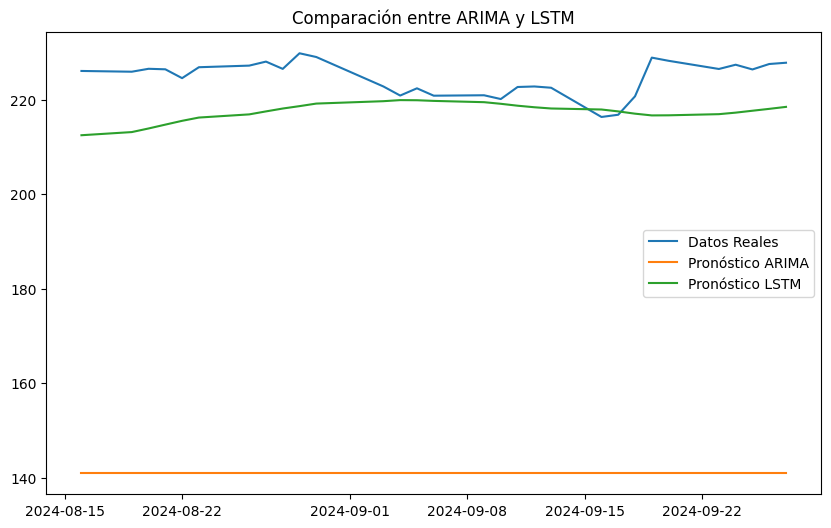

In [79]:

plt.figure(figsize=(10,6))
plt.plot(real_data.index, real_data, label='Datos Reales')
plt.plot(real_data.index, forecast_arima_test[-30:], label='Pronóstico ARIMA')
plt.plot(real_data.index, lstm_predictions_test_rescaled[-30:], label='Pronóstico LSTM')
plt.legend()
plt.title('Comparación entre ARIMA y LSTM')
plt.show()


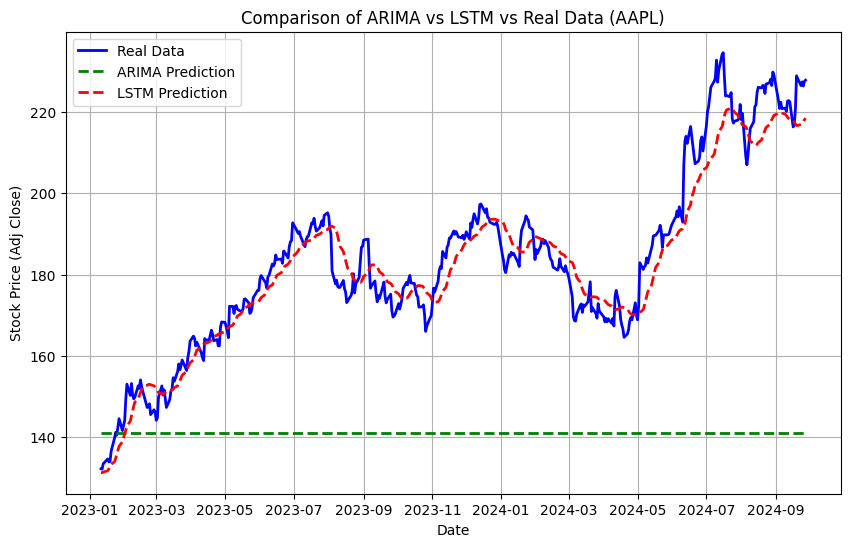

In [80]:
plt.figure(figsize=(10,6))
plt.plot(test_data.index[time_step:], test_data['Adj Close'][time_step:], label='Real Data', color='blue', linewidth=2)
plt.plot(test_data.index[time_step:], forecast_arima_test[time_step:], label='ARIMA Prediction', color='green', linestyle='dashed', linewidth=2)
plt.plot(test_data.index[time_step:], lstm_predictions_test_rescaled, label='LSTM Prediction', color='red', linestyle='dashed', linewidth=2)
plt.title('Comparison of ARIMA vs LSTM vs Real Data (AAPL)')
plt.xlabel('Date')
plt.ylabel('Stock Price (Adj Close)')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
from pmdarima.arima import auto_arima

In [82]:
auto_model = auto_arima(train_data, seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7545.325, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7554.016, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7549.975, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7549.713, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7554.546, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7552.471, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7552.464, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7543.740, Time=0.83 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7552.676, Time=0.43 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=7545.542, Time=0.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7545.519, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7551.673, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=7552.886, Time=0.50 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=7547.625, Time=1.20 sec
 ARIMA(3,1,2)(0,0,0)[0]          

In [83]:
auto_model

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

In [84]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1960
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -3764.870
Date:                Thu, 03 Oct 2024   AIC                           7543.740
Time:                        15:00:49   BIC                           7582.802
Sample:                             0   HQIC                          7558.098
                               - 1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0621      0.037      1.683      0.092      -0.010       0.134
ar.L1          0.9020      0.027     33.895      0.000       0.850       0.954
ar.L2         -0.9041      0.020    -44.243      0.000      -0.944      -0.864
ar.L3         -0.0508      0.014     -3.668      0.000      -0.078      -0.024
ma.L1         -0.9632      0.023    -42.045      0.000      -1.008      -0.918
ma.L2          0.9362      0.020     47.116      0.000       0.897       0.975
sigma2         2.7332      0.042     65.737      0.000       2.652       2.815
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4032.65
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              45.82   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
forecast_auto_arima = auto_model.predict(n_periods=len(test_data))

/Users/rodz/Documents/projects/Time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/rodz/Documents/projects/Time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [86]:
forecast_auto_arima

1960    140.775570
1961    140.131437
1962    139.964418
1963    140.491091
1964    141.211953
           ...    
2446    169.183533
2447    169.242482
2448    169.301438
2449    169.360403
2450    169.419371
Length: 491, dtype: float64

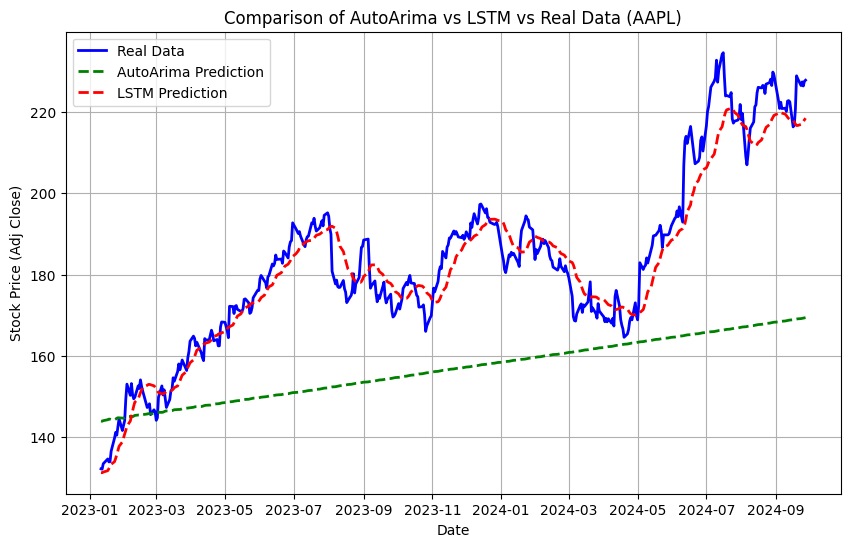

In [87]:
plt.figure(figsize=(10,6))
plt.plot(test_data.index[time_step:], test_data['Adj Close'][time_step:], label='Real Data', color='blue', linewidth=2)
plt.plot(test_data.index[time_step:], forecast_auto_arima[time_step:], label='AutoArima Prediction', color='green', linestyle='dashed', linewidth=2)
plt.plot(test_data.index[time_step:], lstm_predictions_test_rescaled, label='LSTM Prediction', color='red', linestyle='dashed', linewidth=2)
plt.title('Comparison of AutoArima vs LSTM vs Real Data (AAPL)')
plt.xlabel('Date')
plt.ylabel('Stock Price (Adj Close)')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
real_data = data_close["Adj Close"][-30:]

rmse_arima_test = np.sqrt(mean_squared_error(test_data, forecast_auto_arima))
mae_arima_test = mean_absolute_error(test_data, forecast_auto_arima)
print(f'ARIMA RMSE (Test): {rmse_arima_test}')
print(f'ARIMA MAE (Test): {mae_arima_test}')

ARIMA RMSE (Test): 29.568419120369335
ARIMA MAE (Test): 24.467562843797758


# Evalucion

Luego de probar 3 modelos, la red LSTM logra modelar muy bien el pronostico del precio de cierre de AAPL.

# a) Planteamiento de pregunta de investigación:
Pregunta:
¿Qué modelo predictivo (ARIMA, LSTM u otro) ofrece las predicciones más precisas para los precios futuros de las acciones de Apple (AAPL)?

El objetivo es analizar cuál de los modelos seleccionados es capaz de capturar mejor las tendencias y fluctuaciones del precio de las acciones de AAPL. Compararemos los resultados de diferentes enfoques para identificar cuál predice con mayor exactitud, basándonos en métricas como el error cuadrático medio (MSE) y la precisión visual.

# b) Descripción de los datos:
Origen de los datos:
Los datos utilizados en este análisis corresponden a los precios ajustados de cierre de las acciones de Apple (AAPL), descargados desde Yahoo Finance. El rango de fechas seleccionado va desde el 1 de enero de 2015 hasta el 30 de septiembre de 2024.

Atributos de la tabla:

- Date: Fecha de cada observación.
- Adj Close: Precio de cierre ajustado, que considera eventos como dividendos o divisiones de acciones.

El precio de cierre ajustado es el principal atributo utilizado para las predicciones.



# c) Descripción de los modelos:
Se analizaron tres tipos de modelos predictivos de series temporales:

- ARIMA (AutoRegressive Integrated Moving Average)

El modelo ARIMA se ajusta bien a series temporales que son estacionarias (o se transforman en estacionarias mediante diferenciación). Para este análisis se utilizó la función auto_arima que selecciona automáticamente los parámetros p, d y q más adecuados para los datos. Este modelo captura patrones lineales y tiene un enfoque basado en la media y la autocorrelación.

- LSTM (Long Short-Term Memory)
LSTM es un tipo de red neuronal recurrente diseñada para manejar secuencias de datos temporales y capturar dependencias a largo plazo. A diferencia de ARIMA, LSTM puede captar patrones no lineales y complejos en los datos. El modelo LSTM fue entrenado usando 60 pasos de tiempo para predecir el valor futuro.


## Gráficas
Se incluyeron gráficas que comparan los valores reales con las predicciones de ambos modelos a lo largo del tiempo, lo cual permite una comparación visual.

# d) Pruebas sobre los modelos:
### Evaluación de ARIMA
El modelo auto_arima ajustó bien la tendencia de los datos, pero las predicciones resultaron ser demasiado lineales, ya que se centró en capturar una tendencia positiva sin captar la estacionalidad ni las fluctuaciones diarias del precio.

Métricas de evaluación:
RMSE: 29.56

Predicciones visuales: Presentó una línea recta con pendiente positiva, que no reflejó las fluctuaciones reales.

### Evaluación de LSTM
El modelo LSTM fue capaz de captar mejor las fluctuaciones y picos en los datos, aunque mostró cierta inestabilidad en los valores predichos.

Métricas de evaluación:
RMSE: 6.25

Predicciones visuales: Las predicciones no siguieron perfectamente el curso real de los precios, pero capturaron las fluctuaciones con mayor precisión.

### Comparación y validación


Ambas predicciones fueron evaluadas visualmente y mediante el cálculo del error cuadrático medio (MSE). Las predicciones de LSTM lograron un mejor ajuste a los valores reales en comparación con ARIMA, aunque también fueron más susceptibles a variaciones extremas debido a su capacidad para captar dependencias a largo plazo

# e) Conclusiones:

## Respuesta a la pregunta de investigación:
Según los resultados, el modelo LSTM superó al modelo ARIMA en la predicción de precios futuros de las acciones de Apple (AAPL). Si bien ARIMA fue capaz de capturar la tendencia general, no pudo modelar las fluctuaciones diarias, lo cual fue mejor logrado por LSTM.

## Lecciones aprendidas:
Trabajar con modelos de series temporales implica desafíos como la necesidad de transformar los datos a una forma estacionaria en algunos casos (ARIMA), y ajustar adecuadamente los hiperparámetros en modelos más complejos como LSTM. La complejidad de los datos financieros implica que, en muchos casos, modelos como LSTM pueden proporcionar un ajuste superior cuando las series presentan no linealidades.

## Situaciones difíciles con los datos:
Uno de los mayores retos fue la no estacionariedad de los datos. Para ARIMA, fue necesario aplicar diferencias en la serie, mientras que LSTM pudo trabajar directamente con los datos escalados. Los datos financieros también presentaron picos extremos y variaciones rápidas, que fueron difíciles de modelar para ambos enfoques.

## Otros comentarios:
Aunque LSTM fue más preciso, es importante considerar que su entrenamiento es mucho más costoso computacionalmente en comparación con ARIMA, lo que puede ser una limitación en aplicaciones donde se requiera una respuesta rápida. Para futuros trabajos, sería interesante incorporar más variables exógenas (como índices bursátiles o tasas de interés) para mejorar las predicciones.